In [90]:
import sys
sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

In [12]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [3]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"

In [4]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [5]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [6]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [7]:
# twd_tree_series_sites

In [8]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [9]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [91]:
# Configure features
config = FeatureConfig()
lag_n =13

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)




# # non-autoregressive

# Split data
train_df, val_df, test_df = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=False
)

train_df, val_df, test_df = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts, train_day_feat_X, train_static_X_ts,  train_y = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=False,
    shift = 1,
    config=config
)

val_X_ts, val_day_feat_X, val_static_X_ts, val_y = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=False,
    shift = 1,
    config=config
)






### build RNN
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [92]:

batch_size = 64
lag_n = 13

### Non-autoregressive

In [93]:
# dynamic input
timesteps = lag_n
n_features = train_X_ts.shape[2] # include TWD + other variables

dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")

x_dyn = tf_keras.layers.LSTM(32, return_sequences=False)(dyn_in)
x_dyn = tf_keras.layers.Dense(32, activation="relu")(x_dyn)


# current day other features
n_static = train_day_feat_X.shape[1]
static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
x_static = tf_keras.layers.Dense(4, 
                                 activation="relu",
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                 )(static_in)


# static input
n_current = train_static_X_ts.shape[1]
curr_in = tf_keras.Input(shape=(n_current,), name="static")
x_curr = tf_keras.layers.Dense(4, 
                               activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                               )(curr_in)



combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
x = tf_keras.layers.Dense(16, activation="relu")(combined)
out = tf_keras.layers.Dense(1)(x)


model = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
)

model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss="mse",
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)

In [94]:
# building datasets
batch_size = batch_size

train_ds = tf.data.Dataset.from_tensor_slices((
    (train_X_ts, train_day_feat_X, train_static_X_ts),
    train_y,
))
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_X_ts))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((
    (val_X_ts, val_day_feat_X, val_static_X_ts),
    val_y,
))
val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [95]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
)


Epoch 1/50


236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5371 - mae: 0.5137 - rmse: 0.7271 - val_loss: 0.3709 - val_mae: 0.4546 - val_rmse: 0.6022
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3973 - mae: 0.4377 - rmse: 0.6236 - val_loss: 0.3810 - val_mae: 0.4528 - val_rmse: 0.6104
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3486 - mae: 0.4057 - rmse: 0.5833 - val_loss: 0.3083 - val_mae: 0.3827 - val_rmse: 0.5476
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3225 - mae: 0.3885 - rmse: 0.5605 - val_loss: 0.2980 - val_mae: 0.3923 - val_rmse: 0.5383
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2978 - mae: 0.3735 - rmse: 0.5381 - val_loss: 0.2782 - val_mae: 0.3583 - val_rmse: 0.5197
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2788 - mae: 0.3631 - rmse: 0.5203 - val_loss: 0.2978 - val_mae: 0.3657 - val_rmse: 0.5384
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2638 - mae: 0.3546 - rmse: 0.5059 - v

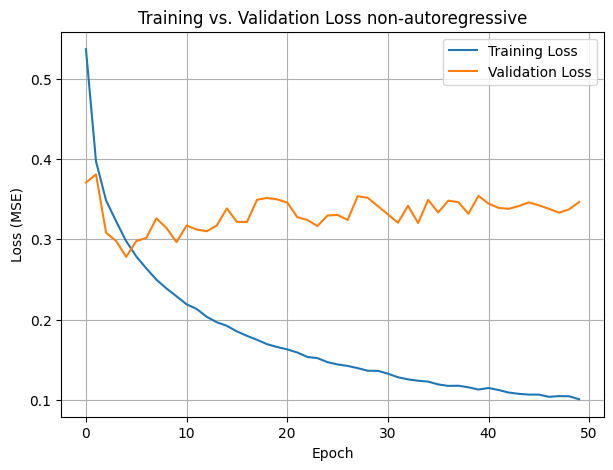

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
rmse: 0.585400, r2: 0.440579 


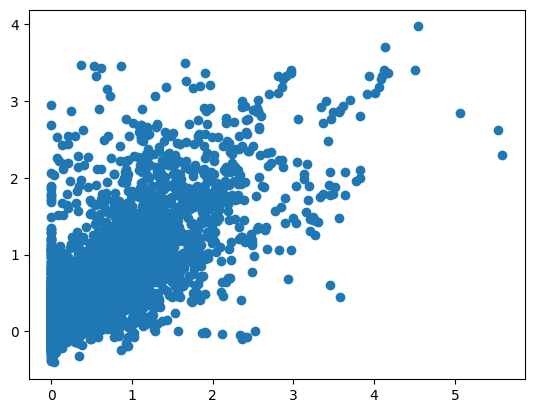

In [96]:


# Extract loss values
train_loss= history.history["loss"]
val_loss = history.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Training vs. Validation Loss non-autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day= model.predict(val_ds)# show first few predictions

rmse_1day = root_mean_squared_error(y_pred_val_1day, val_y)
r2_1day = r2_score(val_y, y_pred_val_1day)
print(f'rmse: {rmse_1day:3f}, r2: {r2_1day:3f} ')
plt.scatter(val_y, y_pred_val_1day)

### Autoregressive

In [97]:
# dynamic input
timesteps = lag_n
n_features = train_X_ts_at.shape[2] # include TWD + other variables

dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")

x_dyn = tf_keras.layers.LSTM(32, return_sequences=False)(dyn_in)
x_dyn = tf_keras.layers.Dense(32, activation="relu")(x_dyn)


# current day other features
n_static = train_day_feat_X.shape[1]
static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
x_static = tf_keras.layers.Dense(4, 
                                 activation="relu",
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                 )(static_in)


# static input
n_current = train_static_X_ts.shape[1]
curr_in = tf_keras.Input(shape=(n_current,), name="static")
x_curr = tf_keras.layers.Dense(4, 
                               activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                               )(curr_in)



combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
x = tf_keras.layers.Dense(16, activation="relu")(combined)
out = tf_keras.layers.Dense(1)(x)


model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
)

model_at.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss="mse",
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)

In [98]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [99]:
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2329 - mae: 0.2876 - rmse: 0.4744 - val_loss: 0.0784 - val_mae: 0.1798 - val_rmse: 0.2672
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0801 - mae: 0.1691 - rmse: 0.2715 - val_loss: 0.0607 - val_mae: 0.1562 - val_rmse: 0.2342
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0662 - mae: 0.1496 - rmse: 0.2467 - val_loss: 0.0519 - val_mae: 0.1400 - val_rmse: 0.2167
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0601 - mae: 0.1410 - rmse: 0.2357 - val_loss: 0.0465 - val_mae: 0.1289 - val_rmse: 0.2056
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0567 - mae: 0.1360 - rmse: 0.2297 - val_loss: 0.0432 - val_mae: 0.1240 - val_rmse: 0.1989
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0540 - mae: 0.1324 - rmse: 0.2250 - val_loss: 0.0424 - val_mae: 0.1236 - val_rmse: 0.1981
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0521 - mae: 0.1295 - rmse:

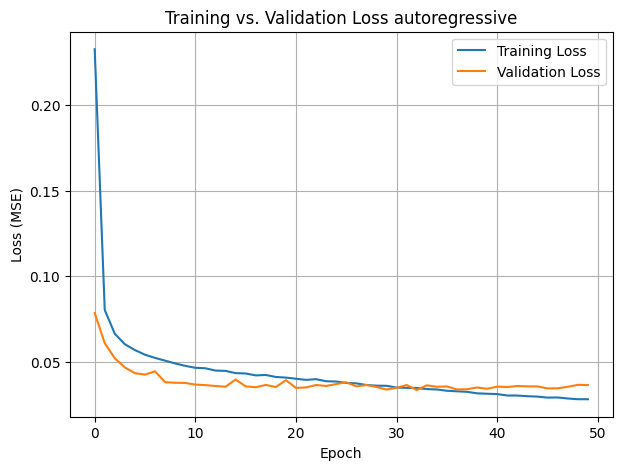

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
rmse: 0.188831, r2: 0.941792 


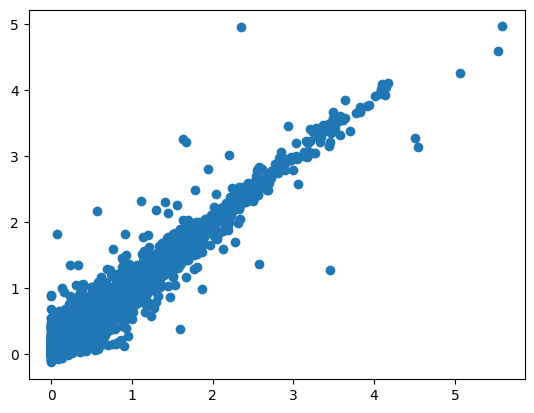

In [101]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(y_pred_val_1day_at, val_y_at)
r2_1day_at = r2_score(val_y_at, y_pred_val_1day_at)
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(val_y_at, y_pred_val_1day_at)

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━

In [102]:
r2_at = r2_score(y_val_at, y_pred_val_at)
rmse_at = root_mean_squared_error(y_val_at, y_pred_val_at)

print(f"r2: {r2_score(y_val_at, y_pred_val_at)}\n rmse: {root_mean_squared_error(y_val_at, y_pred_val_at)}")

r2: 0.4776152347049182
 rmse: 0.5783814726822295


 37/236 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")


236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i+rmse_1day for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i-rmse_1day for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.48773576.taoj/ipykernel_3006864/713734198.py:70: UserWarning: color is redundantly defined by the 'color' k

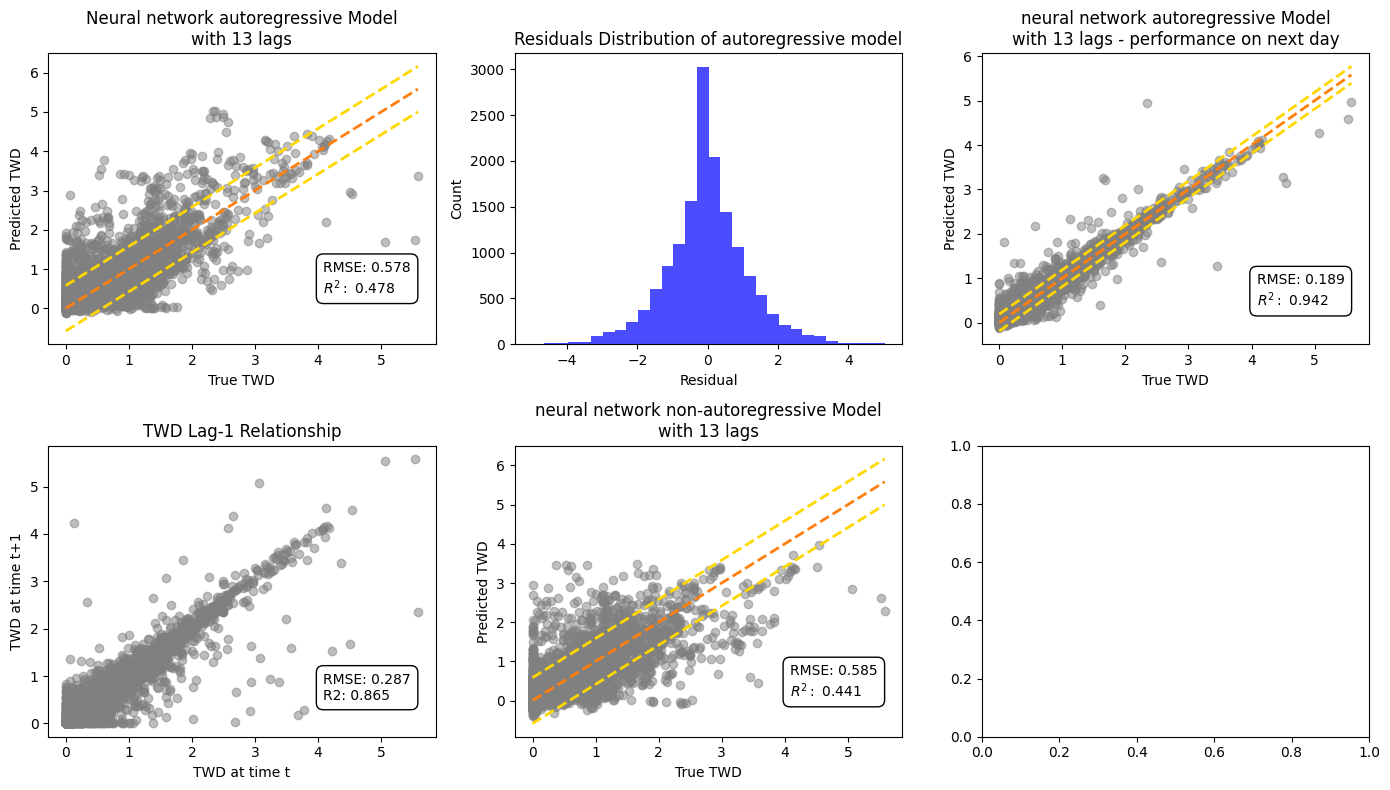

In [114]:
# Create figure with 3 subplots arranged in 1 row and 3 columns

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
val_y_at = ensure_numpy(val_y_at).reshape(-1)
y_pred_val_at = ensure_numpy(y_pred_val_at).reshape(-1)
val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax5), (ax3, ax4, _)) = plt.subplots(2, 3, figsize=(14, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at - model_at.predict(train_ds_at).reshape(-1)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
rmse_lag1 = root_mean_squared_error(val_df["twd"][:-1], val_df['twd'][1:])
r2_score_lag1 = r2_score(val_df["twd"][:-1], val_df['twd'][1:])

ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax4.scatter(x=val_y, y=y_pred_val_1day.reshape(-1), color="grey", alpha=0.5)
ax4.set_xlabel("True TWD")
ax4.set_ylabel("Predicted TWD")
x_range = [val_y.min(), val_y.max()]
ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax4.plot(x_range, [i+rmse_1day for i in x_range], 'k--', lw=2, color="gold")
ax4.plot(x_range, [i-rmse_1day for i in x_range], 'k--', lw=2, color="gold")
ax4.set_title(f"neural network non-autoregressive Model\nwith {lag_n} lags")
ax4.text(val_y.max()-1.5,y_pred_val_1day.min()+0.5, 
         f"RMSE: {rmse_1day:.3f}\n$R^2:$ {r2_1day:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax5.scatter(x=val_y_at, y=y_pred_val_1day_at.reshape(-1), color="grey", alpha=0.5)
ax5.set_xlabel("True TWD")
ax5.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax5.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax5.plot(x_range, [i+rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
ax5.plot(x_range, [i-rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
ax5.set_title(f"neural network autoregressive Model\nwith {lag_n} lags - performance on next day")
ax5.text(val_y_at.max()-1.5,y_pred_val_1day_at.min()+0.5, 
         f"RMSE: {rmse_1day_at:.3f}\n$R^2:$ {r2_1day_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))







# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()